# LSTM 방법론을 활용한 시계열 데이터 예측

### library 불러오기

In [1]:
# tensorflow와 keras가 설치되어 있지 않은 경우 아래 ! pip 코드를 실행
# ! pip install tensorflow
# ! pip install keras


# 라이브러리 블러오기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, load_model
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils

from datetime import datetime, timedelta, timezone

### 데이터 불러오기

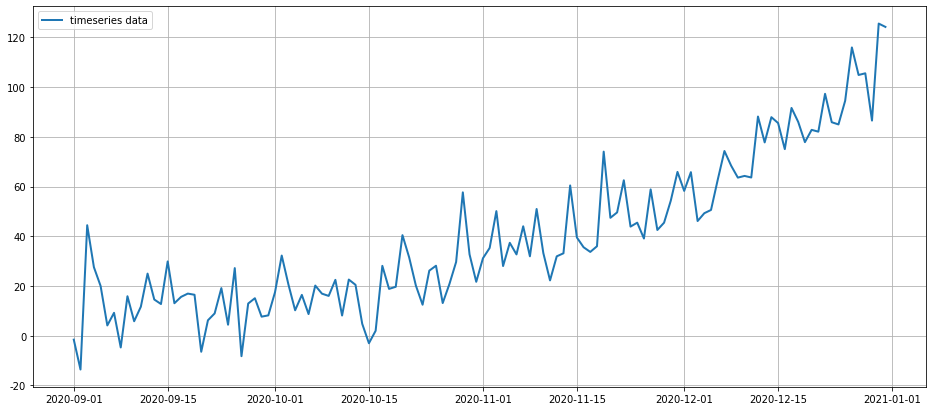

In [2]:
# 데이터 불러오기
df = pd.read_csv('time_series_samp.csv', header = None)

# 컬럼명 정의
df.columns = ['date','value']

# 인덱스 정의
df.index = df["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# 불필요한 컬럼 제거
df = df.drop(['date'], axis=1)


# 시각화 옵션
plt.rcParams["figure.figsize"] = (16,7)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

# 시각화하기
plt.plot(df['value'], label = 'timeseries data')
plt.legend()
plt.show()

### 분석 목표
 - 2020년 9월 1일부터 12월 20일까지 시계열 데이터를 활용하여 LSTM 예측 모델을 구축한 후 12월 26일부터 31일까지 5일을 예측해 보기 

### 데이터 전처리

In [3]:
# train data와 test 데이터로 나누기
train = df[:'2020-12-24']

# 스케일링 하기(-1 ~ 1 으로 스케일링)
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

# 스케일링 기준 정의
scaler.fit(df)

# 훈련 데이터 스케일링
scaled_train = scaler.transform(train)

# 시계열 예측을 위한 타임 스텝 정의
time_step= 10

# 타임 스텝에 따라서 훈련 데이터 나누기
n_rows = len(scaled_train)

features_set_train = []
labels_set_train = []

for i in range(time_step, n_rows):
    features_set_train.append(scaled_train[i-time_step:i])
    labels_set_train.append(scaled_train[i])

features_train, features_val, labels_train, labels_val = train_test_split(features_set_train, labels_set_train, test_size=0.2, shuffle=False)

print('feature_train의 타입 :', type(features_train))
print('labels_train의 타입 :', type(labels_train))

feature_train의 타입 : <class 'list'>
labels_train의 타입 : <class 'list'>


In [4]:
# LSTM 모델에 활용하기 위하여 array 형태로 변경(np.array)
features_train, labels_train = np.array(features_train), np.array(labels_train)
features_val, labels_val = np.array(features_val), np.array(labels_val)


# array의 차원을 변경(np.reshape)
features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))
features_val = np.reshape(features_val, (features_val.shape[0], features_val.shape[1], 1))


print('features_train의 타입 :', type(features_train))
print('features_train의 차원 :', features_train.shape)

features_train의 타입 : <class 'numpy.ndarray'>
features_train의 차원 : (84, 10, 1)


### 분석에서 활용할 모듈 정의

In [5]:
# 손실(loss) 이력 클래스 정의 - 모델 학습 과정을 살펴보기 위해서
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        
# Early stopping
early_stop_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30)

# Model checkpoint (최적의 모델을 저장하는 모듈)
model_checkpoint = ModelCheckpoint(filepath = 'LSTM_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

### LSTM 모델 구성하기

In [6]:
# LSTM model - 단층 모형

# sequential 모델 선언
model = Sequential()

## LSTM layer
model.add(LSTM(units = 70, batch_input_shape = (1, features_train.shape[1], 1), activation = 'tanh'))

## Dense Layer (활성화 함수 = tanh)
model.add(Dense(units = 1, activation = 'tanh'))

# model name
model._name = 'model'

## compile
model.compile(optimizer = 'adam', loss = 'mse', metrics = ["mse","mae",'mape'])

### 모델 학습하기

In [7]:
# 손실 이력 객체 생성
history = LossHistory()
history.init()


# epoch(훈련 반복 횟수) 정의
num_epochs = 100

# 모형 fitting 하기 
model.fit(features_train, labels_train, validation_data = (features_val, labels_val), epochs=num_epochs, batch_size=1, verbose=1, shuffle=False, callbacks=[history,model_checkpoint])

Epoch 1/100
75/84 [=========================>....] - ETA: 0s - loss: 0.0476 - mse: 0.0476 - mae: 0.1704 - mape: 76.6334
Epoch 00001: val_loss improved from inf to 0.08184, saving model to LSTM_model.h5
84/84 [==============================] - 1s 7ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1663 - mape: 88.2334 - val_loss: 0.0818 - val_mse: 0.0818 - val_mae: 0.2568 - val_mape: 87.4402
Epoch 2/100
82/84 [============================>.] - ETA: 0s - loss: 0.0332 - mse: 0.0332 - mae: 0.1436 - mape: 83.2240
Epoch 00002: val_loss improved from 0.08184 to 0.07205, saving model to LSTM_model.h5
84/84 [==============================] - 0s 3ms/step - loss: 0.0331 - mse: 0.0331 - mae: 0.1438 - mape: 83.7840 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2400 - val_mape: 82.3937
Epoch 3/100
65/84 [======================>.......] - ETA: 0s - loss: 0.0337 - mse: 0.0337 - mae: 0.1457 - mape: 71.0874
Epoch 00003: val_loss improved from 0.07205 to 0.05861, saving model to LSTM_model.h5
84/84 [=====

### 저장된 최적의 모델을 불러오고 학습과정 살펴보기

In [8]:
# 저장된 최적으 모형을 불러와서 model 에 저장하여 활용
model = load_model('LSTM_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 70)                   20160     
_________________________________________________________________
dense (Dense)                (1, 1)                    71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


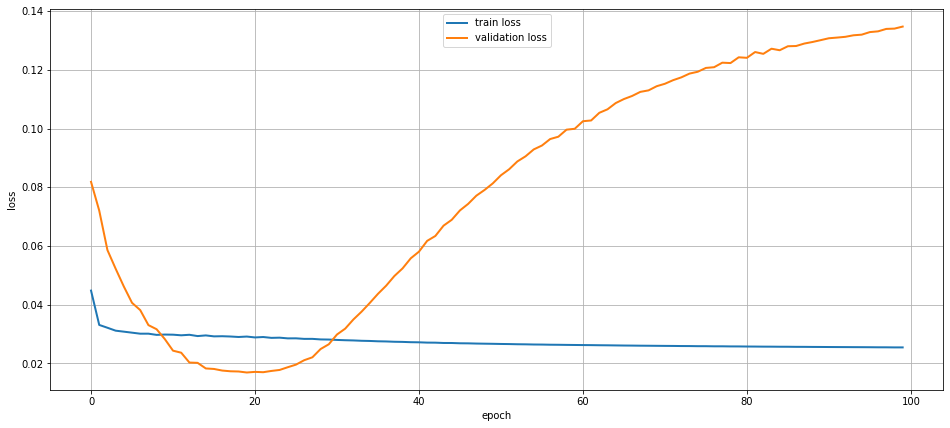

In [9]:
# 6. 학습과정 살펴보기

plt.plot(history.losses)
plt.plot(history.val_losses)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'], loc='upper center')
plt.show()

### 모델 평가해 보기

In [10]:
# 7. 모델 평가하기
scores = model.evaluate(features_train, labels_train, batch_size=1) # 훈련데이터로 평가
scores = model.evaluate(features_val, labels_val, batch_size=1)     # 밸리데이션 데이터로 평가

21/21 [==============================] - 0s 1ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1038 - mean_absolute_percentage_error: 40.4267


### 예측 수행하기

In [11]:
# 예측 수행하기

# 예측 모델에 들어갈 초기값 설정
seq_in = scaled_train[-time_step:]

# 예측구간 계산을 위해 평균값과 표준편차, 상한, 하한을 담을 그릇 선언
mean_pred_val = []

# 몇 개를 예측할지 정의
pred_count = (df.index[-1]-train.index[-1]).days      # 미래의 7일을 예측.

# 반복적인 예측을 수행하기 위해 for loop 구성 -> pred_count 만큼 반복
for i in range(pred_count):
    
    # 예측 모델에 들어가는 input 데이터 구성
    sample_in = np.array(seq_in)
    sample_in = np.reshape(seq_in, (seq_in.shape[1], seq_in.shape[0], 1)) # 샘플 수, 타입스텝 수, 속성 수

    
    # 실제 예측(prediction)
    pred_out = model.predict(sample_in)
 

    # 예측값을 다시 입력 데이터에 추가
    seq_in = np.append(seq_in, np.reshape(pred_out[0], (1,1)), axis = 0)
    seq_in = np.delete(seq_in, [0], axis = 0)
    
    
    # 실제값으로 표현하기 위해 inverse 스케일링
    pred = scaler.inverse_transform(pred_out)
    mean_pred_val.append(pred)
        
    # 반복 횟수를 출력
    print(i+1, '/', pred_count, 'days')
    

# 최종 예측값과 예측구간 상한과 하한을 데이터 프레임으로 만들기
pred_df = pd.DataFrame({'mean_predict_value':mean_pred_val},
                        index = pd.date_range(start = df.index[-pred_count], periods = pred_count, freq='D'))

1 / 7 days
2 / 7 days
3 / 7 days
4 / 7 days
5 / 7 days
6 / 7 days
7 / 7 days


### 예측 결과물 시각화 하기

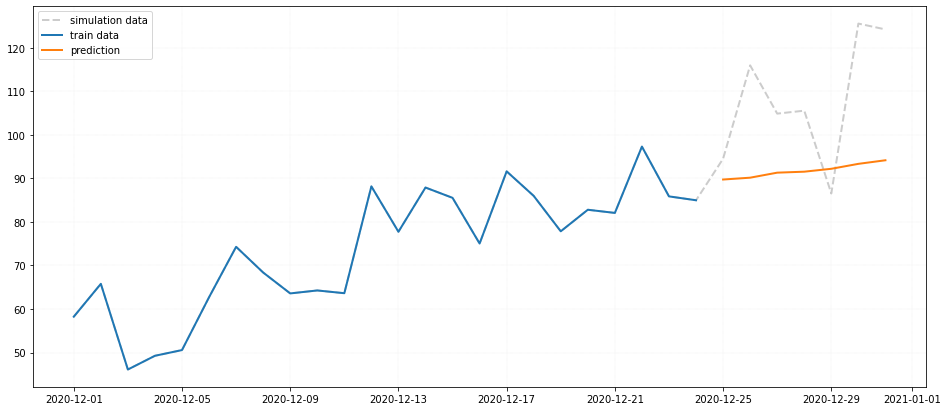

In [12]:
# 최종 결과를 시각화
plt.plot(df['2020-12-01':], color = 'grey', alpha = 0.4, linestyle = 'dashed', lw = 2)
plt.plot(train['2020-12-01':])
plt.plot(pred_df['mean_predict_value'])

plt.grid(True, lw=0.1, linestyle = 'dashed')
plt.legend(['simulation data','train data','prediction','95% CI'])
